g16

anderdav@students.zhaw.ch

goodnic1@students.zhaw.ch

janick.rueegger@students.fhnw.ch

neyerjoh@students.zhaw.ch

In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

### Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

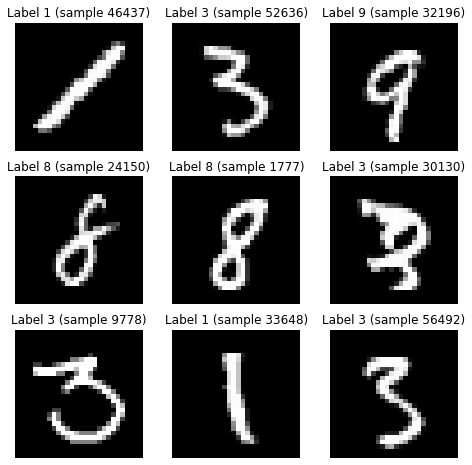

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [7]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


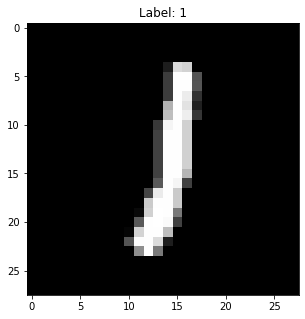

In [8]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [9]:
# slide 21, 42
# Why is the solution for this in the lecture slides?

def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    returns -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    nb = x.shape[0]
    return x.reshape(nb, -1) @ W.T + b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    returns -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    s = torch.exp(z)
    nb = z.shape[1]
    return s / (s @ torch.ones(nb,nb))
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    returns propability for each digit -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    return softmax(linear_trsf(x, W, b))
    # YOUR CODE (END)


##### TEST

In [10]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())
u = predict(data_train[0:2], W, b)
print(u)
print(u.sum(dim=1)) # should be [1, 1]

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 0.9999999403953552
tensor([[4.2677e-08, 6.4169e-08, 2.8771e-07, 3.9496e-06, 6.1151e-07, 2.0570e-02,
         4.5655e-09, 1.9893e-01, 9.4309e-08, 7.8049e-01],
        [1.7368e-09, 4.8077e-07, 1.8336e-09, 1.5932e-04, 2.7448e-08, 9.9540e-01,
         1.0535e-07, 5.2234e-06, 1.0261e-08, 4.4321e-03]])
tensor([1.0000, 1.0000])


#### Loss Function

In [11]:
# Why is the solution for this in the lecture slides?

# slide 24, 43
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    if y.dim() == 1: # make function work with both one-hot and non-one-hot y
        y = torch.nn.functional.one_hot(y, uhat.shape[1])
    return -torch.log(uhat[y == 1])
    # YOUR CODE (END)

# slide 23, 43
def cost_ce(y,uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(y, uhat))
    # YOUR CODE (END)


##### TEST

In [12]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### Gradient Descent for the given Model

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [13]:
# Why is the solution for this in the lecture slides?

# slide 36, 43
def grad_loss_ce(x, u, uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10) (one-hot vectors)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    gradW = torch.mean((uhat - u).view(-1, 10, 1) * x.view(-1, 1, 28*28), dim=0)
    gradb = torch.mean((uhat - u), dim=0)
    return gradW, gradb
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [14]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10) (one-hot vectors)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)
    nb = Y.shape[0]
    Yhat = predict(X, W, b)
    
    cost = cost_ce(Y, Yhat)
    acc = torch.mean(Yhat[Y == 1])
    
    return cost, acc
    # YOUR CODE (END)

### Mini-Batch Gradient Descent

In [15]:
# Why is the solution for this in the lecture slides?
# slide 53

nepochs = 10
alpha = 0.01
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 
Ytest_onehot = torch.nn.functional.one_hot(Ytest, nclasses).float()

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

for epoch in range(nepochs):
    for X, Y in train_dataloader:
        Yhat = predict(X, W, b)
        Y = torch.nn.functional.one_hot(Y, nclasses).float()
        dW, db = grad_loss_ce(X, Y, Yhat)
        W = W - alpha * dW
        b = b - alpha * db
        
    cost, acc = metrics(X, Y, W, b)
    cost_test, acc_test = metrics(Xtest, Ytest_onehot, W, b)  
    
    cost_hist.append(cost)
    acc_hist.append(acc)
    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)
        
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    
d = datetime.now()
print("mean duration per epoch [s]: {:.2f}".format((d-d0).total_seconds() / nepochs))

Epoch 0: 3.140837, 0.448327, 3.071879, 0.459368
Epoch 1: 2.771806, 0.522462, 2.044601, 0.600599
Epoch 2: 1.195592, 0.715781, 1.638100, 0.664578
Epoch 3: 1.475183, 0.656993, 1.413106, 0.702135
Epoch 4: 1.447235, 0.690427, 1.267692, 0.727153
Epoch 5: 0.734695, 0.790807, 1.166237, 0.746798
Epoch 6: 0.791270, 0.808860, 1.089581, 0.761241
Epoch 7: 0.802001, 0.765453, 1.030488, 0.772781
Epoch 8: 1.534456, 0.697082, 0.981034, 0.781640
Epoch 9: 1.357234, 0.735278, 0.940581, 0.789604
mean duration per epoch [s]: 3.19


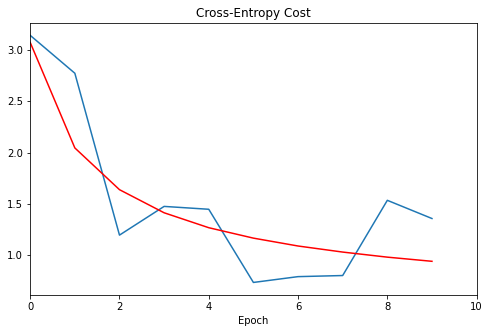

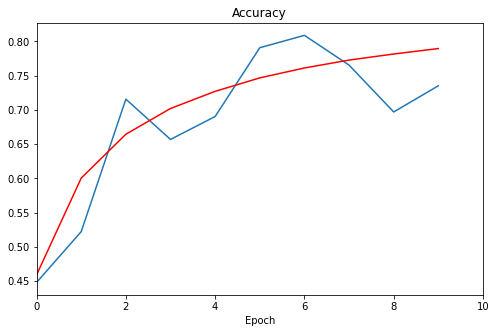

In [16]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
#plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
#plt.ylim(0.8,1)
plt.title("Accuracy")
plt.show()

### With Full-Fledge PyTorch

In [17]:
# Why is the solution for this in the lecture slides?
# slide 66

class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28, 10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z

In [18]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [19]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [20]:
# slide 67

# reset model
# Please put this in the provided notebook. During testing I ran this cell a
# bunch of times and it took me a while to figure out why the accuracy was
# already around 0.8 in the first epoch.
model = NeuralNetwork()

nbatch = 64
learning_rate = .01
nepochs = 10

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        Yhat = model(X)
        
        loss = cost_ce(Yhat, Y)
          
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc += (Yhat.argmax(dim=1) == Y).float().sum().item()
        cost += loss.item()  
    cost /= nbatches
    acc /= size
    
    acc_test = cost_test = 0.0
    with torch.no_grad():
        for X, Y in test_loader:
            Yhat = model(X)
            
            loss_test = cost_ce(Yhat, Y)
            
            acc_test += (Yhat.argmax(dim=1) == Y).float().sum().item()
            cost_test += loss_test.item()

    acc_test /= len(test_loader.dataset)
    
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.981825, 0.802683, 0.600561, 0.867900
Epoch 1: 0.550969, 0.867650, 0.476414, 0.882300
Epoch 2: 0.471607, 0.879783, 0.426010, 0.889800
Epoch 3: 0.432873, 0.886533, 0.397942, 0.895800
Epoch 4: 0.408877, 0.891417, 0.379525, 0.899700
Epoch 5: 0.392106, 0.894483, 0.365865, 0.902700
Epoch 6: 0.379551, 0.897200, 0.355093, 0.904900
Epoch 7: 0.369678, 0.899533, 0.347253, 0.907200
Epoch 8: 0.361516, 0.900933, 0.340407, 0.908500
Epoch 9: 0.354830, 0.902500, 0.335328, 0.908700


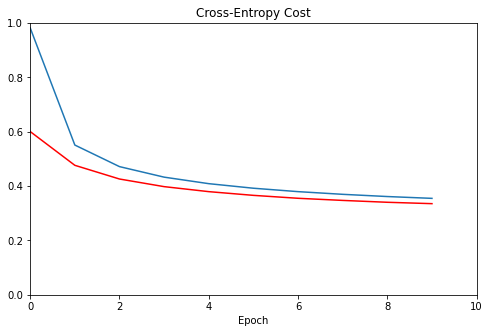

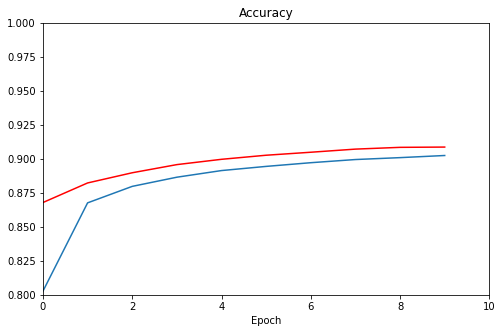

In [21]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")
plt.show()

### Analysis of different settings for learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Can you explain the behavior?

I don't understand how I am supposed to properly select learning rates and batch sizes so bellow are a few that I tried. Am I supposed to read the linked papers on slide 61?

It seems like higher batch sizes and learning rates increase the noise.

When the learning rate is too low it takes far too long and when the its too high no good solution is found.

When changing the batch size and keeping the learning rate at 0.01 the accuracy gets worse.

In [22]:
print(f"nbatch = {nbatch}", f"learning_rate = {learning_rate}", f"nepochs = {nepochs}", sep="\n")
print(f"acc_hist = {[round(c, 3) for c in acc_hist]}")
print(f"acc_hist_test = {[round(c, 3) for c in acc_hist_test]}")

nbatch = 64
learning_rate = 0.01
nepochs = 10
acc_hist = [0.803, 0.868, 0.88, 0.887, 0.891, 0.894, 0.897, 0.9, 0.901, 0.902]
acc_hist_test = [0.868, 0.882, 0.89, 0.896, 0.9, 0.903, 0.905, 0.907, 0.908, 0.909]


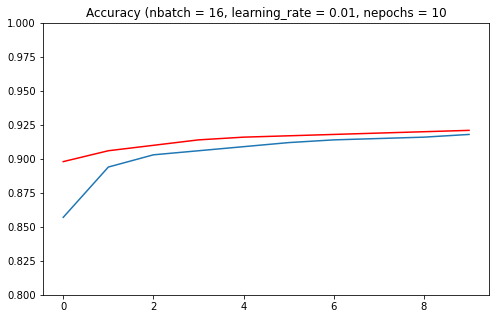

In [23]:
nbatch = 16
learning_rate = 0.01
nepochs = 10
acc_hist = [0.857, 0.894, 0.903, 0.906, 0.909, 0.912, 0.914, 0.915, 0.916, 0.918]
acc_hist_test = [0.898, 0.906, 0.91, 0.914, 0.916, 0.917, 0.918, 0.919, 0.92, 0.921]

plt.plot(torch.arange(nepochs), acc_hist, "-")
plt.plot(torch.arange(nepochs), acc_hist_test, "r-")
plt.ylim(0.8,1)
plt.title(f"Accuracy (nbatch = {nbatch}, learning_rate = {learning_rate}, nepochs = {nepochs}")
plt.show()

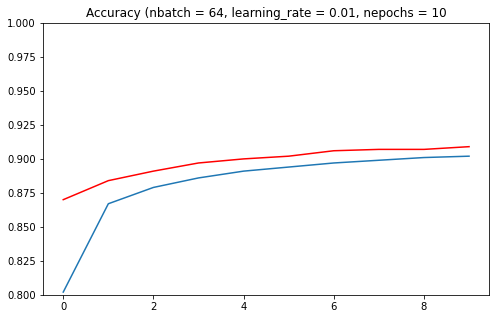

In [24]:
nbatch = 64
learning_rate = 0.01
nepochs = 10
acc_hist = [0.802, 0.867, 0.879, 0.886, 0.891, 0.894, 0.897, 0.899, 0.901, 0.902]
acc_hist_test = [0.87, 0.884, 0.891, 0.897, 0.9, 0.902, 0.906, 0.907, 0.907, 0.909]

plt.plot(torch.arange(nepochs), acc_hist, "-")
plt.plot(torch.arange(nepochs), acc_hist_test, "r-")
plt.ylim(0.8,1)
plt.title(f"Accuracy (nbatch = {nbatch}, learning_rate = {learning_rate}, nepochs = {nepochs}")
plt.show()

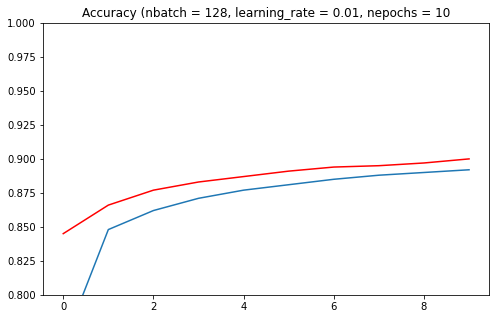

In [25]:
nbatch = 128
learning_rate = 0.01
nepochs = 10
acc_hist = [0.763, 0.848, 0.862, 0.871, 0.877, 0.881, 0.885, 0.888, 0.89, 0.892]
acc_hist_test = [0.845, 0.866, 0.877, 0.883, 0.887, 0.891, 0.894, 0.895, 0.897, 0.9]

plt.plot(torch.arange(nepochs), acc_hist, "-")
plt.plot(torch.arange(nepochs), acc_hist_test, "r-")
plt.ylim(0.8,1)
plt.title(f"Accuracy (nbatch = {nbatch}, learning_rate = {learning_rate}, nepochs = {nepochs}")
plt.show()

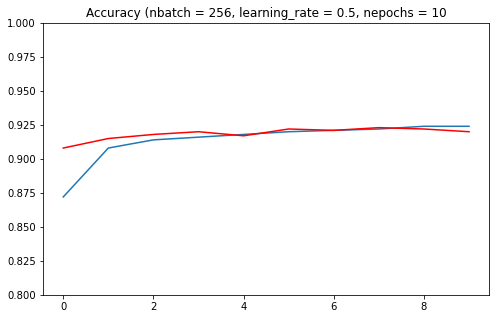

In [26]:
nbatch = 256
learning_rate = 0.5
nepochs = 10
acc_hist = [0.872, 0.908, 0.914, 0.916, 0.918, 0.92, 0.921, 0.922, 0.924, 0.924]
acc_hist_test = [0.908, 0.915, 0.918, 0.92, 0.917, 0.922, 0.921, 0.923, 0.922, 0.92]

plt.plot(torch.arange(nepochs), acc_hist, "-")
plt.plot(torch.arange(nepochs), acc_hist_test, "r-")
plt.ylim(0.8,1)
plt.title(f"Accuracy (nbatch = {nbatch}, learning_rate = {learning_rate}, nepochs = {nepochs}")
plt.show()

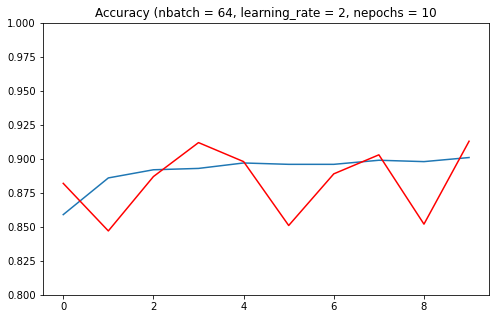

In [27]:
nbatch = 64
learning_rate = 2
nepochs = 10
acc_hist = [0.859, 0.886, 0.892, 0.893, 0.897, 0.896, 0.896, 0.899, 0.898, 0.901]
acc_hist_test = [0.882, 0.847, 0.887, 0.912, 0.898, 0.851, 0.889, 0.903, 0.852, 0.913]

plt.plot(torch.arange(nepochs), acc_hist, "-")
plt.plot(torch.arange(nepochs), acc_hist_test, "r-")
plt.ylim(0.8,1)
plt.title(f"Accuracy (nbatch = {nbatch}, learning_rate = {learning_rate}, nepochs = {nepochs}")
plt.show()

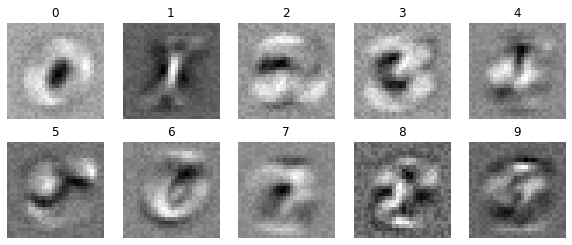

In [28]:
weights = dict(model.named_parameters())["linear.weight"].detach()

figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2
for i in range(nclasses):
    figure.add_subplot(rows, cols, i + 1)
    plt.imshow(weights[i,:].reshape(28,28), cmap="gray")
    plt.title(f"{i}")
    plt.axis("off")

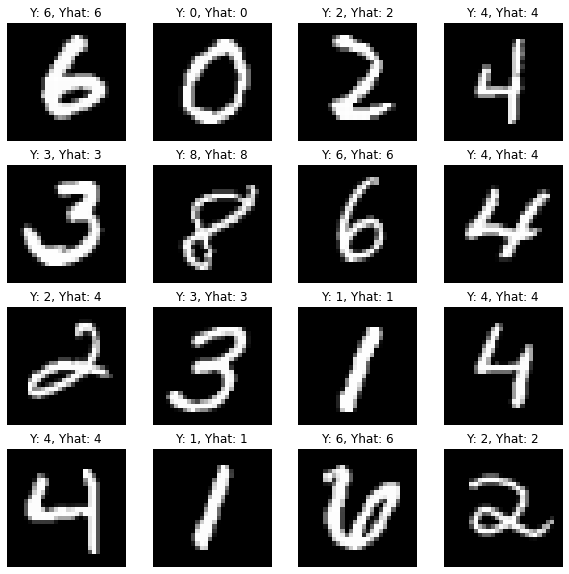

In [29]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    img, label = training_data[randint(len(training_data))]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Y: {label}, Yhat: {model(img).argmax()}")
    plt.axis("off")